# Kütüphanelerin Yüklenmesi


In [1]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [2]:
df = pd.read_csv("/kaggle/input/airline-quality-ratings/Airline Quality Ratings.csv")
df.head(5)

,ID,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,1,Male,48,First-time,Business,Business,821,2,5.0,3,3,4,3,3,3,5,2,5,5,5,3,5,5,Neutral or Dissatisfied
1,2,Female,35,Returning,Business,Business,821,26,39.0,2,2,3,5,2,5,4,5,5,3,5,2,5,5,Satisfied
2,3,Male,41,Returning,Business,Business,853,0,0.0,4,4,4,5,4,3,5,3,5,5,3,4,3,3,Satisfied
3,4,Male,50,Returning,Business,Business,1905,0,0.0,2,2,3,4,2,5,5,5,4,4,5,2,5,5,Satisfied
4,5,Female,49,Returning,Business,Business,3470,0,1.0,3,3,3,5,3,3,4,4,5,4,3,3,3,3,Satisfied


In [3]:
df = df.drop("ID", axis=1)
df.head(5)

,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,Male,48,First-time,Business,Business,821,2,5.0,3,3,4,3,3,3,5,2,5,5,5,3,5,5,Neutral or Dissatisfied
1,Female,35,Returning,Business,Business,821,26,39.0,2,2,3,5,2,5,4,5,5,3,5,2,5,5,Satisfied
2,Male,41,Returning,Business,Business,853,0,0.0,4,4,4,5,4,3,5,3,5,5,3,4,3,3,Satisfied
3,Male,50,Returning,Business,Business,1905,0,0.0,2,2,3,4,2,5,5,5,4,4,5,2,5,5,Satisfied
4,Female,49,Returning,Business,Business,3470,0,1.0,3,3,3,5,3,3,4,4,5,4,3,3,3,3,Satisfied


# Exploratory Data Analysis

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    
check_df(df)

##################### Shape #####################
(129880, 23)
##################### Types #####################
Gender                                     object
Age                                         int64
Customer Type                              object
Type of Travel                             object
Class                                      object
Flight Distance                             int64
Departure Delay                             int64
Arrival Delay                             float64
Departure and Arrival Time Convenience      int64
Ease of Online Booking                      int64
Check-in Service                            int64
Online Boarding                             int64
Gate Location                               int64
On-board Service                            int64
Seat Comfort                                int64
Leg Room Service                            int64
Cleanliness                                 int64
Food and Drink                       

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

# Değişken türlerinin ayrıştırılması
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

In [6]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

In [7]:
# Kategorik değişkenlerin incelenmesi
for col in cat_cols:
    cat_summary(df, col)

        Gender      Ratio
Gender                   
Female   65899  50.738374
Male     63981  49.261626
##########################################
               Customer Type      Ratio
Customer Type                          
Returning             106100  81.690791
First-time             23780  18.309209
##########################################
                Type of Travel      Ratio
Type of Travel                           
Business                 89693  69.058362
Personal                 40187  30.941638
##########################################
              Class      Ratio
Class                         
Business      62160  47.859563
Economy       58309  44.894518
Economy Plus   9411   7.245919
##########################################
                         Satisfaction      Ratio
Satisfaction                                    
Neutral or Dissatisfied         73452  56.553742
Satisfied                       56428  43.446258
##########################################


In [8]:
# Sayısal değişkenlerin incelenmesi
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,129880.0,39.427957,15.119360,7.0,27.0,40.0,51.0,85.0
Flight Distance,129880.0,1190.316392,997.452477,31.0,414.0,844.0,1744.0,4983.0
Departure Delay,129880.0,14.713713,38.071126,0.0,0.0,0.0,12.0,1592.0
Arrival Delay,129487.0,15.091129,38.465650,0.0,0.0,0.0,13.0,1584.0
Departure and Arrival Time Convenience,129880.0,3.057599,1.526741,0.0,2.0,3.0,4.0,5.0
Ease of Online Booking,129880.0,2.756876,1.401740,0.0,2.0,3.0,4.0,5.0
Check-in Service,129880.0,3.306267,1.266185,0.0,3.0,3.0,4.0,5.0
Online Boarding,129880.0,3.252633,1.350719,0.0,2.0,3.0,4.0,5.0
Gate Location,129880.0,2.976925,1.278520,0.0,2.0,3.0,4.0,5.0
On-board Service,129880.0,3.383023,1.287099,0.0,2.0,4.0,4.0,5.0


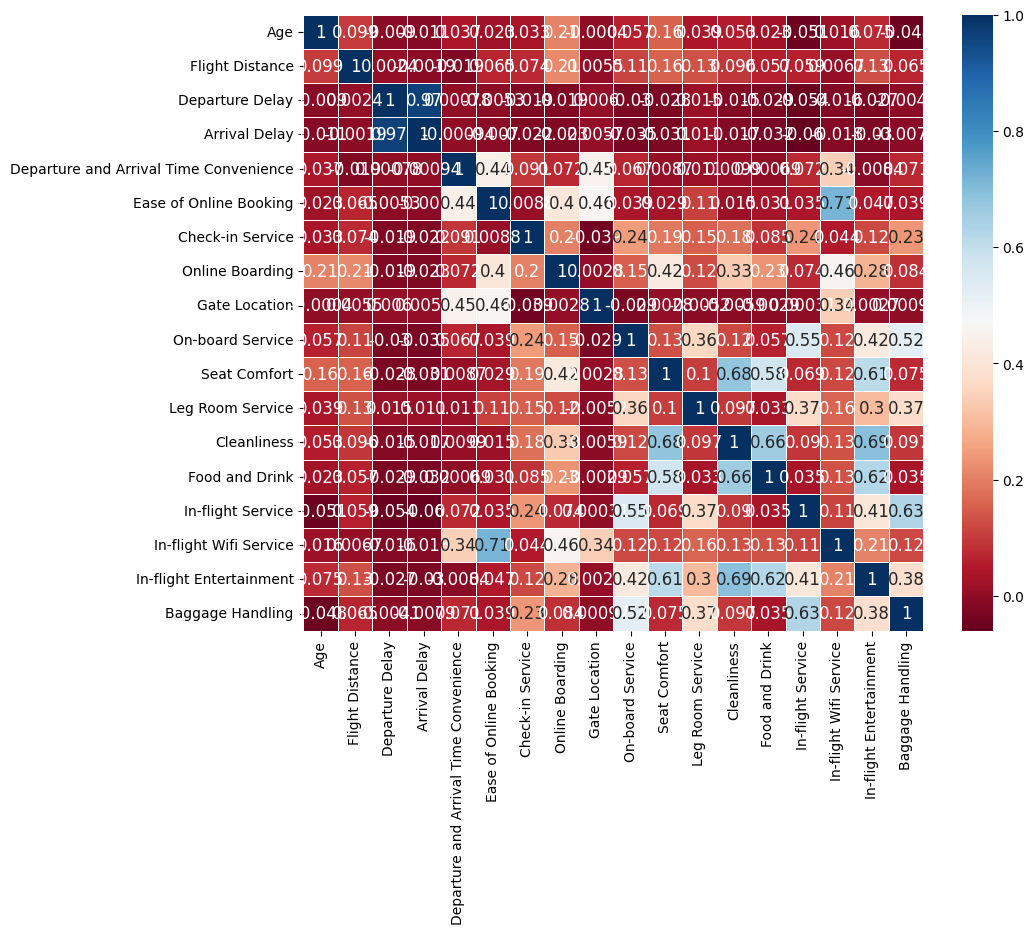

In [9]:
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)
    
# Sayısal değişkenkerin birbirleri ile korelasyonu
correlation_matrix(df, num_cols)

# Data Preprocessing

In [10]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [11]:
cat_cols = [col for col in cat_cols if "Satisfaction" not in col]

df = one_hot_encoder(df, cat_cols, drop_first=True)

In [12]:
for col in num_cols:
    print(col, check_outlier(df, col, 0.05, 0.95))

Age False
Flight Distance False
Departure Delay True
Arrival Delay True
Departure and Arrival Time Convenience False
Ease of Online Booking False
Check-in Service False
Online Boarding False
Gate Location False
On-board Service False
Seat Comfort False
Leg Room Service False
Cleanliness False
Food and Drink False
In-flight Service False
In-flight Wifi Service False
In-flight Entertainment False
Baggage Handling False


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [13]:
replace_with_thresholds(df, "Departure Delay")
replace_with_thresholds(df, "Arrival Delay")

for col in num_cols:
    print(col, check_outlier(df, col, 0.05, 0.95))

Age False
Flight Distance False


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


Departure Delay False
Arrival Delay False
Departure and Arrival Time Convenience False
Ease of Online Booking False
Check-in Service False
Online Boarding False
Gate Location False
On-board Service False
Seat Comfort False
Leg Room Service False
Cleanliness False
Food and Drink False
In-flight Service False
In-flight Wifi Service False
In-flight Entertainment False
Baggage Handling False


In [14]:
df['Satisfaction2'] = df['Satisfaction'].apply(lambda x: 1 if x == 'Satisfied' else 0)
df = df.drop("Satisfaction", axis=1)
df.head()

,Age,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,Check-in Service,Online Boarding,Gate Location,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Gender_Male,Customer Type_Returning,Type of Travel_Personal,Class_Economy,Class_Economy Plus,Satisfaction2
0,48,821,2,5.0,3,3,4,3,3,3,5,2,5,5,5,3,5,5,True,False,False,False,False,0
1,35,821,26,32.5,2,2,3,5,2,5,4,5,5,3,5,2,5,5,False,True,False,False,False,1
2,41,853,0,0.0,4,4,4,5,4,3,5,3,5,5,3,4,3,3,True,True,False,False,False,1
3,50,1905,0,0.0,2,2,3,4,2,5,5,5,4,4,5,2,5,5,True,True,False,False,False,1
4,49,3470,0,1.0,3,3,3,5,3,3,4,4,5,4,3,3,3,3,False,True,False,False,False,1


In [15]:
# Standartlaştırma
X_scaled = StandardScaler().fit_transform(df[num_cols])
df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

In [16]:
y = df["Satisfaction2"]
X = df.drop(["Satisfaction2"], axis=1)
check_df(X)

##################### Shape #####################
(129880, 23)
##################### Types #####################
Age                                       float64
Flight Distance                           float64
Departure Delay                           float64
Arrival Delay                             float64
Departure and Arrival Time Convenience    float64
Ease of Online Booking                    float64
Check-in Service                          float64
Online Boarding                           float64
Gate Location                             float64
On-board Service                          float64
Seat Comfort                              float64
Leg Room Service                          float64
Cleanliness                               float64
Food and Drink                            float64
In-flight Service                         float64
In-flight Wifi Service                    float64
In-flight Entertainment                   float64
Baggage Handling                     

# Modeling

In [17]:
xgboost_model = XGBClassifier(random_state=17)

cv_results = cross_validate(xgboost_model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
print(cv_results["test_accuracy"].mean())
print(cv_results["test_f1"].mean())
print(cv_results["test_roc_auc"].mean())

0.9622420696027101
0.9557446625191316
0.9950155285551867


In [18]:
xgboost_params = {"learning_rate": [0.1, 0.01, 0.001],
                  "max_depth": [5, 8, None],
                  "n_estimators": [100, 500, 1000],
                  "colsample_bytree": [None, 0.7, 1]}

In [19]:
xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=10, n_jobs=-1, verbose=True).fit(X, y)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


In [20]:
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X, y)

In [21]:
cv_results = cross_validate(xgboost_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
print(cv_results["test_accuracy"].mean())
print(cv_results["test_f1"].mean())
print(cv_results["test_roc_auc"].mean())

0.9633199876809362
0.957034184436225
0.9952497927425886


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
model = xgboost_final
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"ROC-AUC: {roc_auc}")

MAE: 0.03549430243301509
MSE: 0.03549430243301509
RMSE: 0.18839931643457491
ROC-AUC: 0.9953265226611159


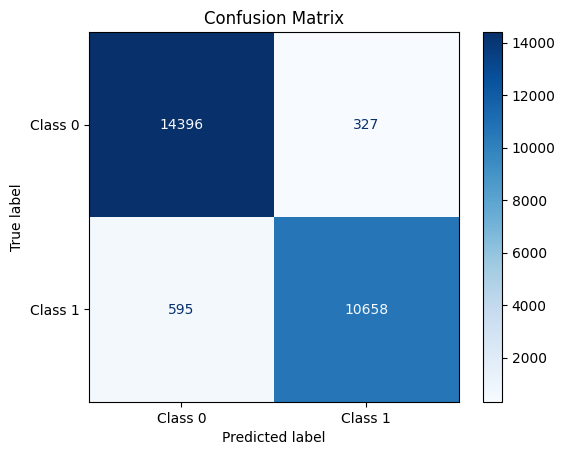

In [23]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()